In [1]:
%pylab inline
import pandas as pd
import spac

Populating the interactive namespace from numpy and matplotlib


In [33]:
pd_inputs = pd.read_csv('../inputs.csv')
atm = {            
            "Date": pd_inputs['Date'].values,
            "sw_rad": pd_inputs['Average Rad flux dens (W/m2)'].values,
            "lw_rad": pd_inputs['Ldown'].values,
            "P": np.ones_like(pd_inputs['Ldown'].values) * 101315,
            "air_temp": pd_inputs['Air Temp Marco (C)'].values,
            "windspeed": pd_inputs['WS'].values,
            "rel_hum": pd_inputs['RH'].values,
        }
    
specs = {
            "gsmax": 0.024,
            "gsmin": 0.00002,
            "LAI": 0.5,
            "RAI": 4,
            "opt_temp": 15,
            "max_temp": 45,
            "min_temp": 0,
            "gs_light_coeff": 350,
            "gs_vpd_coeff": 0.00001,
            "lwp_min": 7,
            "lwp_max": 0.00001,
            "kbeers": 0.55,
            "emissivity": 0.95,
            "sperry_k": 0.316,
            "sperry_d": 0.49,
            "sperry_c": 7.4,

        }

soils = {
            "porosity": 0.6,
            "ksat": 0.00008,
            "thetar": 0.05,
            "rootdepth": 1,
            "psiae": 0.8,
            "bclambda": 3,
            "rr": 0.2,
            "albedo": 0.8,
            "theta0": 0.3,
        }


In [34]:
dt = 3600
model = spac.Spac(atm, soils, specs, dt) 

In [35]:
x0 = (0.4, 0.1, 25)

model.run_spac(x0, num_time_steps=10)

100%|██████████| 10/10 [00:00<00:00, 939.04it/s]


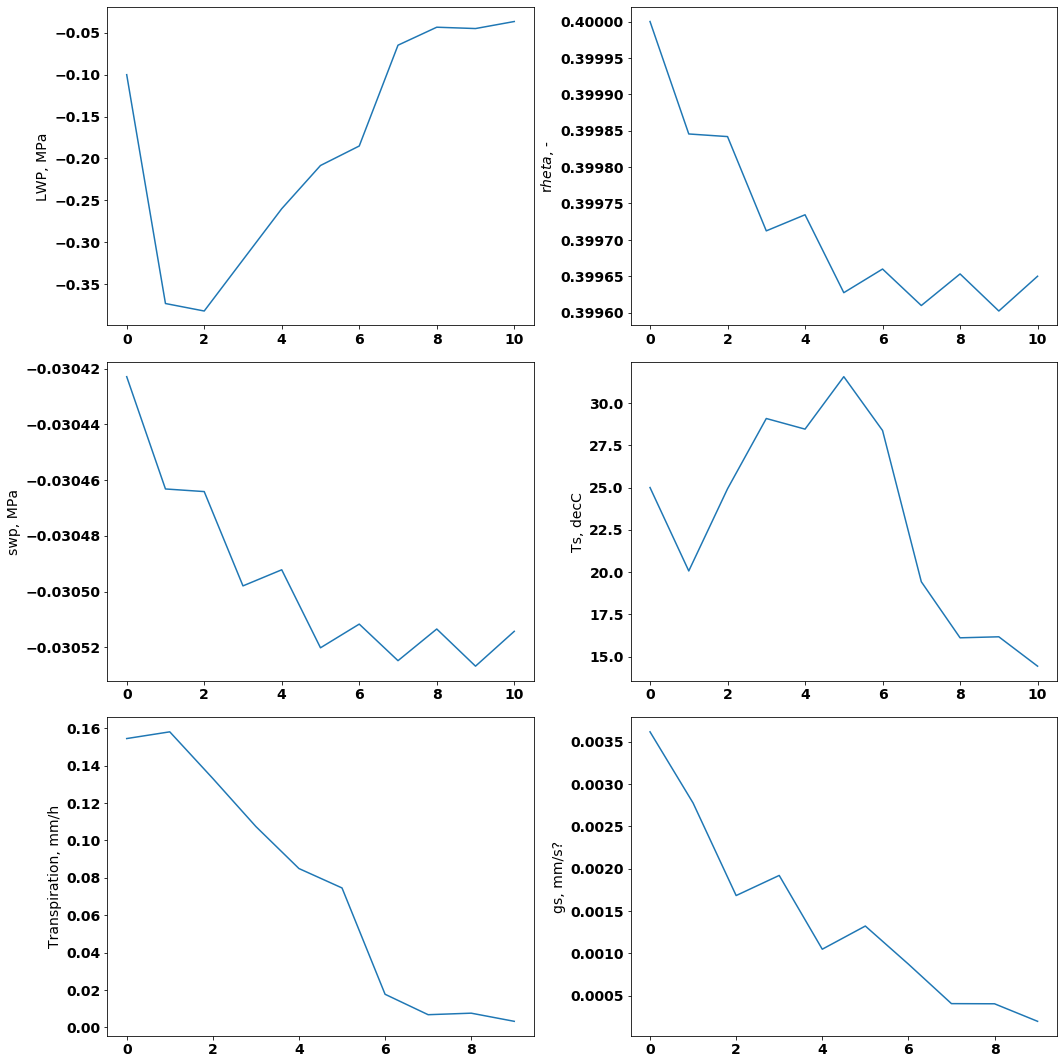

In [36]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
ax[0,0].plot(-1*np.array(model.lwp))
ax[0,0].set_ylabel("LWP, MPa")
ax[0,1].plot(np.array(model.theta))
ax[0,1].set_ylabel("r$\theta$, -")
ax[1,0].plot(-np.array(model.swp))
ax[1,0].set_ylabel("swp, MPa")
ax[1,1].plot(np.array(model.Ts))
ax[1,1].set_ylabel("Ts, decC")
ax[2,0].plot(np.array(model.Transp))
ax[2,0].set_ylabel("Transpiration, mm/h")
ax[2,1].plot(np.array(model.stom_conduct))
ax[2,1].set_ylabel("gs, mm/s?")
plt.tight_layout()

In [37]:
species_stor = {
    "osm_sens_par": 0.002807,  # MPa umol-1 m2 s of PAR
    "osm_pot_dark": -1.7952,  # MPa
    "rwc_loss_turgor": 1,
    "pressure_loss_turgor": 0.5,  # MPa
    "leaf_bulk_modulus": 1.5,  # MPa
    "elastic_modulus_guard_cell": 267.2209306  # MPa m-1 s
}

In [38]:
model2 = spac.StorageSpac(atm, soils, specs, species_stor, dt) 

In [39]:
x0 = (0.4, 0.1, 25, -1.7952, 0.001)

model2.run_spac(x0, num_time_steps=None)

100%|██████████| 6906/6906 [00:05<00:00, 1373.55it/s]


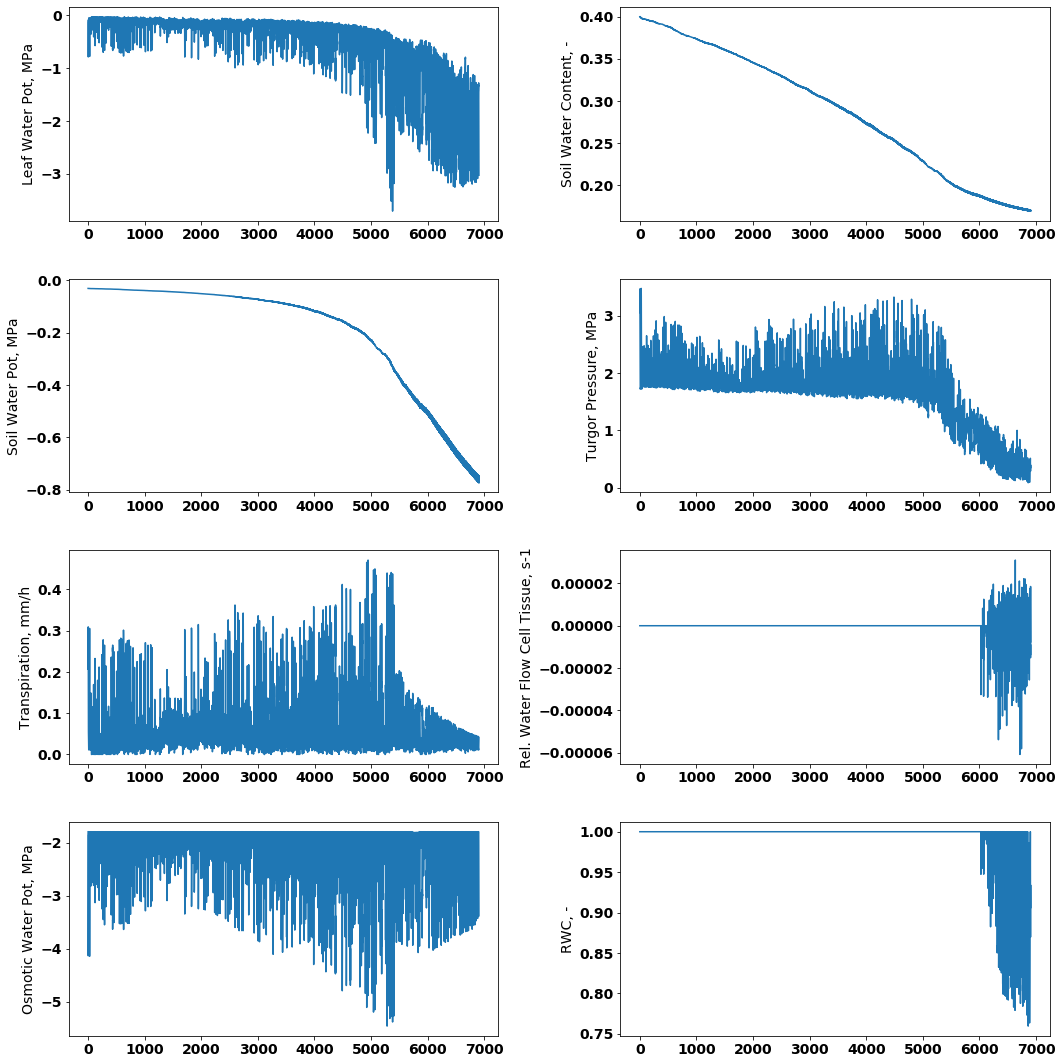

In [28]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(4,2, figsize=(15,15))
ax[0,0].plot(-1*np.array(model2.lwp))
ax[0,0].set_ylabel("Leaf Water Pot, MPa")
ax[0,1].plot(np.array(model2.theta))
ax[0,1].set_ylabel("Soil Water Content, -")
ax[1,0].plot(-np.array(model2.swp))
ax[1,0].set_ylabel("Soil Water Pot, MPa")
ax[1,1].plot(np.array(model2.twp))
ax[1,1].set_ylabel("Turgor Pressure, MPa")
ax[2,0].plot(np.array(model2.Transp))
ax[2,0].set_ylabel("Transpiration, mm/h")
model2.delta_f[0]=0
ax[2,1].plot(np.array(model2.delta_f))
ax[2,1].set_ylabel("Rel. Water Flow Cell Tissue, s-1")
ax[3,0].plot(np.array(model2.owp))
ax[3,0].set_ylabel("Osmotic Water Pot, MPa")
ax[3,1].plot(np.array(model2.canopy_rel_wat_cont))
ax[3,1].set_ylabel("RWC, -")
plt.tight_layout()
plt.savefig("advanced_spac.pdf")

[0.35804823 0.64526586 0.17840125]


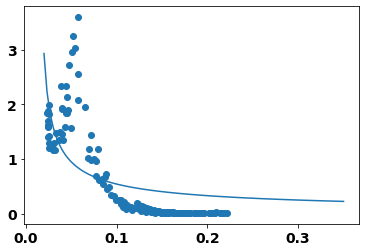

In [149]:
soil_obs = pd.read_csv("../All_Data_Plants_5PM_Caelan.csv" ,usecols=['Measurement.Time','CP_WP_mean_MPa', 'CP_WP_sd_MPa',
       'RMR_WP_mean_MPa', 'RMR_WP_sd_MPa', 'CP_VWC_bot_mean_.',
       'CP_VWC_bot_sd_.', 'RMR_VWC_bot_mean_.', 'RMR_VWC_bot_sd_.',
       'CP_VWC_top_mean_.', 'CP_VWC_top_sd_.', 'RMR_VWC_top_mean_.',
       'RMR_VWC_top_sd_.'])

def brooks_corey(theta, psiae, bclambda, poros):
    #psiae , bclambda, poros, thetar = x
    S = (theta - thetar) / (poros - thetar)
    psi = np.abs(psiae)  / S ** bclambda
    return psi

from scipy.optimize import curve_fit

theta = (soil_obs['CP_VWC_bot_mean_.']/100).values
swp = soil_obs['CP_WP_mean_MPa'].values
sigma_WP = soil_obs['CP_WP_sd_MPa'].values

thetar = theta.min()-0.01


pars, _ = curve_fit(brooks_corey, theta, -swp, p0=(.02, .8, 0.2),
              #sigma=sigma_WP, 
              bounds=[(0.01, 0.02, 0.02), (np.inf, np.inf, 0.9)])

x = np.linspace(0.35, 0.02, 100)
print(pars)
#pars = (2, 0.4, 0.6)
plt.scatter(theta, -swp)
plt.plot(x, brooks_corey(x, *pars))


#plt.scatter(-soil_obs['CP_WP_mean_MPa'], soil_obs['CP_VWC_top_mean_.']/100)

In [151]:
obs_plant = pd.read_excel("../Master_Data_Caelan.xlsx")
obs_plant

Date      Time Treatment          Design_moment  Days_Drying Race  \
0  2017-05-18  13:38:00        C2  After Preconditioning            0   CP   
1  2017-05-18  12:16:00        C2  After Preconditioning            0   CP   
2  2017-05-18  13:44:00        C2  After Preconditioning            0   CP   
3  2017-05-18  14:01:00        C2  After Preconditioning            0   CP   
4  2017-05-18  12:28:00        C2  After Preconditioning            0   CP   
..        ...       ...       ...                    ...          ...  ...   
85 2017-07-22  12:52:00        M8               Dry-down           72  RMR   
86 2017-07-22  12:43:00        M8               Dry-down           72  RMR   
87 2017-07-22  12:00:00        M8               Dry-down           72  RMR   
88 2017-07-22  12:19:00        M8               Dry-down           72  RMR   
89 2017-07-22  12:17:00        M8               Dry-down           72  RMR   

    Sample_ID  Soil_Temp_bottom  Soil_VWC_bottom  Soil_WP_Mpa_from_VWC  ...  \
0          94              22.6            0.271              0.820808  ...   
1        1087              19.4            0.224              0.558737  ...   
2        1097              19.5            0.235              0.624697  ...   
3        1098              20.8            0.147             -0.020808  ...   
4        1129              19.2            0.205              0.436783  ...   
..        ...               ...              ...                   ...  ...   
85         67              26.8            0.015             -3.161125  ...   
86        160              28.2            0.020             -2.765305  ...   
87       1234              26.1            0.029             -2.254073  ...   
88       1238              25.2            0.014             -3.256052  ...   
89       1264              28.4            0.024             -2.514450  ...   

    RWC_plant_%  Stem_Conductivity_mmol.s-1.MPA-1.m-1  \
0     90.175032                           2235.345970   
1     87.808690                           1296.787495   
2     88.052843                            779.341965   
3     91.033373                            939.212117   
4           NaN                           3404.907746   
..          ...                                   ...   
85    50.515171                            298.028369   
86    32.903897                             81.391705   
87    80.685699                           1070.767651   
88    49.028297                              0.436423   
89    24.455315                            919.808933   

    Stem_Conductance_mmol.s-1.MPA.-1.m-2  \
0                           91989.546110   
1                           38710.074472   
2                           20563.112524   
3                           22469.189406   
4                           87305.326809   
..                                   ...   
85                           9582.905747   
86                           2981.381131   
87                          36297.208512   
88                             16.044978   
89                          33816.504884   

    Root_Conductance_mmol.s-1.MPA.-1.m-2  Stem_PLC_%  Root_PLCe_%  \
0                           19579.375899  -29.127223    29.800622   
1                           60268.602609   25.089641  -116.085458   
2                            7573.561861   54.980453    72.845951   
3                           39377.743809   45.745377   -41.183924   
4                           12656.195722  -96.688248    54.622810   
..                                   ...         ...          ...   
85                           5845.194856   80.950950    82.085464   
86                           9511.825955   94.797694    70.847858   
87                          24752.441720   31.559850    24.137940   
88                          28612.381891   99.972105    12.307875   
89                          19513.772665   41.208663    40.193578   

    Plant_PLC_%  Root_shoot_ratio P_mortality  \
0     12.385673          1.1159